<a href="https://colab.research.google.com/github/rahulkumar1502/ERA-V2/blob/main/ERA_V2_S9_Rahul_Kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import sys
sys.path.append('/content')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Net
from utils import LoadDataset

In [3]:
dataloader = LoadDataset()
train,test = dataloader.getData()

100%|██████████| 170498071/170498071 [01:49<00:00, 1552242.95it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train and Test data loaded


In [4]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


images.shape: torch.Size([64, 3, 32, 32])
labels.shape: torch.Size([64])


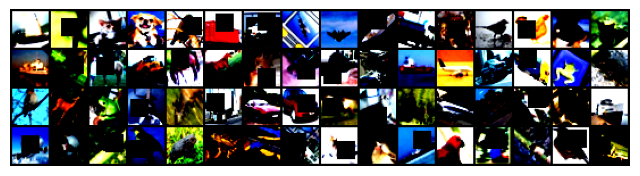

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [6]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
           Conv2d-10           [-1, 32, 30, 30]           4,608
             ReLU-11           [-1, 32, 30, 30]               0
      BatchNorm2d-12           [-1, 32, 30, 30]              64
          Dropout-13           [-1, 32, 30, 30]               0
           Conv2d-14           [-1, 32,

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 55
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8753032684326172 Batch_id=781 Accuracy=34.64: 100%|██████████| 782/782 [04:38<00:00,  2.80it/s]



Test set: Average loss: 1.4640, Accuracy: 4628/10000 (46.28%)

EPOCH: 1


Loss=1.355095386505127 Batch_id=781 Accuracy=45.32: 100%|██████████| 782/782 [05:21<00:00,  2.43it/s] 



Test set: Average loss: 1.2238, Accuracy: 5620/10000 (56.20%)

EPOCH: 2


Loss=1.018053650856018 Batch_id=781 Accuracy=50.70: 100%|██████████| 782/782 [05:00<00:00,  2.60it/s] 



Test set: Average loss: 1.1406, Accuracy: 5914/10000 (59.14%)

EPOCH: 3


Loss=1.0995601415634155 Batch_id=781 Accuracy=54.11: 100%|██████████| 782/782 [40:00<00:00,  3.07s/it]   



Test set: Average loss: 1.0290, Accuracy: 6305/10000 (63.05%)

EPOCH: 4


Loss=0.9913708567619324 Batch_id=781 Accuracy=56.58: 100%|██████████| 782/782 [05:20<00:00,  2.44it/s]



Test set: Average loss: 0.9534, Accuracy: 6644/10000 (66.44%)

EPOCH: 5


Loss=1.1140215396881104 Batch_id=781 Accuracy=58.69: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]



Test set: Average loss: 0.8853, Accuracy: 6934/10000 (69.34%)

EPOCH: 6


Loss=0.5997273325920105 Batch_id=781 Accuracy=60.35: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s]



Test set: Average loss: 0.8353, Accuracy: 7022/10000 (70.22%)

EPOCH: 7


Loss=1.5117071866989136 Batch_id=781 Accuracy=61.63: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]



Test set: Average loss: 0.8131, Accuracy: 7181/10000 (71.81%)

EPOCH: 8


Loss=0.8394284844398499 Batch_id=781 Accuracy=62.82: 100%|██████████| 782/782 [04:37<00:00,  2.82it/s]



Test set: Average loss: 0.7595, Accuracy: 7359/10000 (73.59%)

EPOCH: 9


Loss=1.8807862997055054 Batch_id=781 Accuracy=64.04: 100%|██████████| 782/782 [04:37<00:00,  2.82it/s]



Test set: Average loss: 0.7556, Accuracy: 7382/10000 (73.82%)

EPOCH: 10


Loss=1.4147396087646484 Batch_id=781 Accuracy=64.29: 100%|██████████| 782/782 [12:05<00:00,  1.08it/s]



Test set: Average loss: 0.7060, Accuracy: 7533/10000 (75.33%)

EPOCH: 11


Loss=1.5323930978775024 Batch_id=781 Accuracy=65.53: 100%|██████████| 782/782 [05:18<00:00,  2.46it/s]



Test set: Average loss: 0.7309, Accuracy: 7511/10000 (75.11%)

EPOCH: 12


Loss=1.0734368562698364 Batch_id=781 Accuracy=66.40: 100%|██████████| 782/782 [04:39<00:00,  2.80it/s]



Test set: Average loss: 0.7053, Accuracy: 7586/10000 (75.86%)

EPOCH: 13


Loss=0.9181366562843323 Batch_id=781 Accuracy=66.60: 100%|██████████| 782/782 [04:41<00:00,  2.78it/s]



Test set: Average loss: 0.6499, Accuracy: 7745/10000 (77.45%)

EPOCH: 14


Loss=0.6983124017715454 Batch_id=781 Accuracy=67.28: 100%|██████████| 782/782 [09:50<00:00,  1.32it/s]  



Test set: Average loss: 0.6621, Accuracy: 7702/10000 (77.02%)

EPOCH: 15


Loss=1.220356822013855 Batch_id=781 Accuracy=67.56: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s] 



Test set: Average loss: 0.6305, Accuracy: 7836/10000 (78.36%)

EPOCH: 16


Loss=0.948293149471283 Batch_id=781 Accuracy=68.33: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s] 



Test set: Average loss: 0.6285, Accuracy: 7831/10000 (78.31%)

EPOCH: 17


Loss=1.0704516172409058 Batch_id=781 Accuracy=68.54: 100%|██████████| 782/782 [14:52<00:00,  1.14s/it]



Test set: Average loss: 0.6323, Accuracy: 7831/10000 (78.31%)

EPOCH: 18


Loss=1.2557536363601685 Batch_id=781 Accuracy=69.21: 100%|██████████| 782/782 [18:28<00:00,  1.42s/it]



Test set: Average loss: 0.5853, Accuracy: 8024/10000 (80.24%)

EPOCH: 19


Loss=1.029276728630066 Batch_id=781 Accuracy=69.62: 100%|██████████| 782/782 [17:04<00:00,  1.31s/it] 



Test set: Average loss: 0.5887, Accuracy: 7954/10000 (79.54%)

EPOCH: 20


Loss=0.778643012046814 Batch_id=781 Accuracy=69.94: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.5821, Accuracy: 8018/10000 (80.18%)

EPOCH: 21


Loss=1.4075603485107422 Batch_id=781 Accuracy=70.16: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]



Test set: Average loss: 0.5563, Accuracy: 8102/10000 (81.02%)

EPOCH: 22


Loss=0.9051896333694458 Batch_id=781 Accuracy=70.35: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]



Test set: Average loss: 0.5692, Accuracy: 8051/10000 (80.51%)

EPOCH: 23


Loss=0.9433786869049072 Batch_id=781 Accuracy=70.85: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s] 



Test set: Average loss: 0.5518, Accuracy: 8132/10000 (81.32%)

EPOCH: 24


Loss=0.7316592335700989 Batch_id=781 Accuracy=71.17: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.5599, Accuracy: 8087/10000 (80.87%)

EPOCH: 25


Loss=0.9772989749908447 Batch_id=781 Accuracy=71.40: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.5387, Accuracy: 8156/10000 (81.56%)

EPOCH: 26


Loss=1.0190080404281616 Batch_id=781 Accuracy=71.49: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s] 



Test set: Average loss: 0.5347, Accuracy: 8170/10000 (81.70%)

EPOCH: 27


Loss=1.640477180480957 Batch_id=781 Accuracy=71.70: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]  



Test set: Average loss: 0.5399, Accuracy: 8161/10000 (81.61%)

EPOCH: 28


Loss=1.2087278366088867 Batch_id=781 Accuracy=72.55: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.5498, Accuracy: 8137/10000 (81.37%)

EPOCH: 29


Loss=1.0462613105773926 Batch_id=781 Accuracy=72.20: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.5204, Accuracy: 8199/10000 (81.99%)

EPOCH: 30


Loss=0.7969309091567993 Batch_id=781 Accuracy=72.54: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.5273, Accuracy: 8189/10000 (81.89%)

EPOCH: 31


Loss=0.7667372226715088 Batch_id=781 Accuracy=72.85: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4900, Accuracy: 8300/10000 (83.00%)

EPOCH: 32


Loss=0.5971189141273499 Batch_id=781 Accuracy=72.91: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.5043, Accuracy: 8306/10000 (83.06%)

EPOCH: 33


Loss=1.4840238094329834 Batch_id=781 Accuracy=73.32: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.5389, Accuracy: 8174/10000 (81.74%)

EPOCH: 34


Loss=0.8423210382461548 Batch_id=781 Accuracy=73.07: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.5088, Accuracy: 8265/10000 (82.65%)

EPOCH: 35


Loss=0.7168570160865784 Batch_id=781 Accuracy=73.51: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s] 



Test set: Average loss: 0.4875, Accuracy: 8327/10000 (83.27%)

EPOCH: 36


Loss=0.831786036491394 Batch_id=781 Accuracy=73.89: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s]  



Test set: Average loss: 0.4804, Accuracy: 8382/10000 (83.82%)

EPOCH: 37


Loss=1.0269807577133179 Batch_id=781 Accuracy=73.77: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4894, Accuracy: 8367/10000 (83.67%)

EPOCH: 38


Loss=0.6183909773826599 Batch_id=781 Accuracy=73.84: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4724, Accuracy: 8422/10000 (84.22%)

EPOCH: 39


Loss=0.6823370456695557 Batch_id=781 Accuracy=74.02: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4755, Accuracy: 8396/10000 (83.96%)

EPOCH: 40


Loss=1.4811749458312988 Batch_id=781 Accuracy=74.55: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4849, Accuracy: 8368/10000 (83.68%)

EPOCH: 41


Loss=0.9051825404167175 Batch_id=781 Accuracy=74.25: 100%|██████████| 782/782 [04:33<00:00,  2.86it/s] 



Test set: Average loss: 0.4847, Accuracy: 8382/10000 (83.82%)

EPOCH: 42


Loss=0.5784144401550293 Batch_id=781 Accuracy=74.45: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4582, Accuracy: 8436/10000 (84.36%)

EPOCH: 43


Loss=0.5752741098403931 Batch_id=781 Accuracy=74.70: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4852, Accuracy: 8363/10000 (83.63%)

EPOCH: 44


Loss=0.4215867221355438 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4486, Accuracy: 8470/10000 (84.70%)

EPOCH: 45


Loss=0.8904132843017578 Batch_id=781 Accuracy=74.83: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4559, Accuracy: 8474/10000 (84.74%)

EPOCH: 46


Loss=1.0718215703964233 Batch_id=781 Accuracy=74.71: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4705, Accuracy: 8427/10000 (84.27%)

EPOCH: 47


Loss=0.892289400100708 Batch_id=781 Accuracy=74.89: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s]  



Test set: Average loss: 0.4520, Accuracy: 8457/10000 (84.57%)

EPOCH: 48


Loss=1.1044576168060303 Batch_id=781 Accuracy=75.13: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s] 



Test set: Average loss: 0.4826, Accuracy: 8400/10000 (84.00%)

EPOCH: 49


Loss=0.9299301505088806 Batch_id=781 Accuracy=75.17: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4536, Accuracy: 8447/10000 (84.47%)

EPOCH: 50


Loss=1.1940425634384155 Batch_id=781 Accuracy=75.52: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4486, Accuracy: 8489/10000 (84.89%)

EPOCH: 51


Loss=0.5160152316093445 Batch_id=781 Accuracy=75.43: 100%|██████████| 782/782 [04:31<00:00,  2.88it/s] 



Test set: Average loss: 0.4414, Accuracy: 8524/10000 (85.24%)

EPOCH: 52


Loss=0.6747186779975891 Batch_id=781 Accuracy=75.48: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4529, Accuracy: 8483/10000 (84.83%)

EPOCH: 53


Loss=0.8763611912727356 Batch_id=781 Accuracy=75.94: 100%|██████████| 782/782 [04:32<00:00,  2.87it/s] 



Test set: Average loss: 0.4358, Accuracy: 8524/10000 (85.24%)

EPOCH: 54


Loss=0.83077472448349 Batch_id=781 Accuracy=75.93: 100%|██████████| 782/782 [04:34<00:00,  2.85it/s]   



Test set: Average loss: 0.4498, Accuracy: 8458/10000 (84.58%)

